I add the meaning almost for each cell for starter can easily understand whats the usage. rename some variables name to easy read

# Import some libs

In [3]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [4]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

# Visualize the info about the datasets

## View the files structure

In [5]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

# define the dataset directory
ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'

# print the file structure
list_files(ROOT)

home-credit-credit-risk-model-stability/
    sample_submission.csv
    feature_definitions.csv
    parquet_files/
        test/
            test_deposit_1.parquet
            test_applprev_2.parquet
            test_static_cb_0.parquet
            test_static_0_0.parquet
            test_credit_bureau_a_1_3.parquet
            test_credit_bureau_a_1_2.parquet
            test_tax_registry_b_1.parquet
            test_static_0_2.parquet
            test_credit_bureau_a_2_3.parquet
            test_credit_bureau_a_2_9.parquet
            test_debitcard_1.parquet
            test_credit_bureau_a_1_1.parquet
            test_credit_bureau_a_2_2.parquet
            test_credit_bureau_a_2_11.parquet
            test_applprev_1_2.parquet
            test_credit_bureau_a_2_1.parquet
            test_credit_bureau_a_1_4.parquet
            test_tax_registry_c_1.parquet
            test_applprev_1_0.parquet
            test_tax_registry_a_1.parquet
            test_credit_bureau_a_2_6.parquet
  

## Check the tables size

In [6]:
def get_disk_usage(directory):
    cmd = f'du {directory}/* -h | sort -rh'
    result = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, text=True)
    output_lines = result.stdout.split('\n')

    # Extract file/directory names and sizes
    data = [line.split('\t') for line in output_lines if line]
    df = pd.DataFrame(data, columns=['size', 'path'])
    df['file_name'] = df.path.str.replace('train_|test_', '', regex=True).\
    apply(lambda x: Path(x).stem)
    return df

train_disk_usage = get_disk_usage(f'{ROOT}/csv_files/train').reset_index()
test_disk_usage = get_disk_usage(f'{ROOT}/csv_files/test')

train_disk_usage.reset_index().merge(test_disk_usage, on=['file_name'],
                                     how='outer', suffixes=['_train', '_test'])\
                                     .sort_values(by='index').drop(columns=['index'])

,level_0,size_train,path_train,file_name,size_test,path_test
17,0.0,2.9G,/kaggle/input/home-credit-credit-risk-model-st...,credit_bureau_a_2_5,4.0K,/kaggle/input/home-credit-credit-risk-model-st...
16,1.0,2.4G,/kaggle/input/home-credit-credit-risk-model-st...,credit_bureau_a_2_4,4.0K,/kaggle/input/home-credit-credit-risk-model-st...
15,2.0,2.3G,/kaggle/input/home-credit-credit-risk-model-st...,credit_bureau_a_2_3,4.0K,/kaggle/input/home-credit-credit-risk-model-st...
18,3.0,2.2G,/kaggle/input/home-credit-credit-risk-model-st...,credit_bureau_a_2_6,4.0K,/kaggle/input/home-credit-credit-risk-model-st...
21,4.0,1.6G,/kaggle/input/home-credit-credit-risk-model-st...,credit_bureau_a_2_9,4.0K,/kaggle/input/home-credit-credit-risk-model-st...
14,5.0,1.6G,/kaggle/input/home-credit-credit-risk-model-st...,credit_bureau_a_2_2,4.0K,/kaggle/input/home-credit-credit-risk-model-st...
6,6.0,1.5G,/kaggle/input/home-credit-credit-risk-model-st...,credit_bureau_a_1_1,8.0K,/kaggle/input/home-credit-credit-risk-model-st...
20,7.0,1.2G,/kaggle/input/home-credit-credit-risk-model-st...,credit_bureau_a_2_8,4.0K,/kaggle/input/home-credit-credit-risk-model-st...
7,8.0,949M,/kaggle/input/home-credit-credit-risk-model-st...,credit_bureau_a_1_2,8.0K,/kaggle/input/home-credit-credit-risk-model-st...
5,9.0,837M,/kaggle/input/home-credit-credit-risk-model-st...,credit_bureau_a_1_0,8.0K,/kaggle/input/home-credit-credit-risk-model-st...


## Check the info about base table

In [7]:
# define the dataset directory
PATH_BASE_TRAIN = f'{ROOT}/csv_files/train/train_base.csv'
PATH_BASE_TEST = f'{ROOT}/csv_files/test/test_base.csv'

# load the dataset
train =  pd.read_csv(PATH_BASE_TRAIN)
test =   pd.read_csv(PATH_BASE_TEST)

# Display the shape of the datasets
print('The shape of the train dataset is:', train.shape)
print('The shape of the test dataset is:', test.shape)
print('-------------------------------------------------\n\n')

# Display the first 3 rows of the datasets
print('Display the first 3 rows of the train dataset:')
display(train.head(3))
print('-------------------------------------------------\n\n')
print('Display the first 3 rows of the test dataset:')
display(test.head(3))
print('-------------------------------------------------\n\n')

# Display the data types of the datasets
print('Display the data types of the train dataset:')
display(train.dtypes)
print('-------------------------------------------------\n\n')


The shape of the train dataset is: (1526659, 5)
The shape of the test dataset is: (10, 4)
-------------------------------------------------


Display the first 3 rows of the train dataset:


,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0


-------------------------------------------------


Display the first 3 rows of the test dataset:


,case_id,date_decision,MONTH,WEEK_NUM
0,57543,2021-05-14,202201,100
1,57549,2022-01-17,202201,100
2,57551,2020-11-27,202201,100


-------------------------------------------------


Display the data types of the train dataset:


case_id           int64
date_decision    object
MONTH             int64
WEEK_NUM          int64
target            int64
dtype: object

-------------------------------------------------




## Check infomation about date

In [8]:
def get_date_interval_info(df, df_name):
    if 'date_decision' in df.columns:
        df['date_decision'] = pd.to_datetime(df['date_decision'])
        date_delta = df['date_decision'].drop_duplicates().sort_values().diff()
        len_uniq_dates = len(df.date_decision.unique())
        print(
            f"\n[INFO] {df_name} Actual date range:  {date_delta.sum().days + 1} day(s).",
            f"\n[INFO] {df_name} Total unique dates: {len_uniq_dates} day(s)."
        )

        print(f"\n[INFO] {df_name} Min date: {df.date_decision.dt.date.min()}",
              f"\n[INFO] {df_name} Max date: {df.date_decision.dt.date.max()}")
    else:
        print(f"\n[INFO] The dataframe {df_name} does not contain a 'date_decision' column.")

get_date_interval_info(train, 'Train dataset')
print("\n----------Test data----------")
get_date_interval_info(test, 'Test dataset')


[INFO] Train dataset Actual date range:  644 day(s). 
[INFO] Train dataset Total unique dates: 644 day(s).

[INFO] Train dataset Min date: 2019-01-01 
[INFO] Train dataset Max date: 2020-10-05

----------Test data----------

[INFO] Test dataset Actual date range:  555 day(s). 
[INFO] Test dataset Total unique dates: 9 day(s).

[INFO] Test dataset Min date: 2020-11-27 
[INFO] Test dataset Max date: 2022-06-04


# Define some functions for load dataset

## Three functions in Pipeline (set type based on col name; additional col; drop missing col)

In [9]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        # drop the col if missing value > 0.7
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        # Remove Irrelevant or Overly Complex Categorical Columns:
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df

## Define the aggregation function to help read high depth data file

In [10]:
class Aggregator:
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

## How to read file

In [11]:
def read_file(path, depth = None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by('case_id').agg(Aggregator.get_exprs(df))
    return df

def read_files(regex_path,depth = None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by('case_id').agg(Aggregator.get_exprs(df))
        chunks.append(df)
        
    df = pl.concat(chunks,how = 'vertical_relaxed')
    df = df.unique(subset = ['case_id'])
    return df

## Feature engineering: add new col in df_base & left join different depth file togather

In [12]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

In [13]:
def to_pandas(dataframe, categorical_columns=None):
    # Convert the dataframe to a pandas dataframe
    pandas_df = dataframe.to_pandas()
    
    # If categorical_columns is not provided, identify all object dtype columns as categorical
    if categorical_columns is None:
        categorical_columns = list(pandas_df.select_dtypes("object").columns)
    
    # Convert identified columns to categorical dtype
    pandas_df[categorical_columns] = pandas_df[categorical_columns].astype("category")
    
    # Return the pandas dataframe and the list of categorical columns
    return pandas_df, categorical_columns

## Decrease the memory by using lightest number type

In [14]:
def reduce_mem_usage(dataframe):
    # Calculate the initial memory usage of the DataFrame
    initial_memory_usage = dataframe.memory_usage().sum() / 1024**2
    print(f'Initial memory usage: {initial_memory_usage:.2f} MB')
    
    # Iterate over each column in the DataFrame
    for column_name in dataframe.columns:
        column_dtype = dataframe[column_name].dtype

        # Skip the optimization for categorical columns
        if str(column_dtype) == "category":
            continue

        # Skip optimization for non-numeric columns
        if column_dtype != 'object':
            min_value = dataframe[column_name].min()
            max_value = dataframe[column_name].max()

            # Downcast integer columns to the smallest integer dtype possible
            if 'int' in str(column_dtype):
                if min_value >= np.iinfo(np.int8).min and max_value <= np.iinfo(np.int8).max:
                    dataframe[column_name] = dataframe[column_name].astype(np.int8)
                elif min_value >= np.iinfo(np.int16).min and max_value <= np.iinfo(np.int16).max:
                    dataframe[column_name] = dataframe[column_name].astype(np.int16)
                elif min_value >= np.iinfo(np.int32).min and max_value <= np.iinfo(np.int32).max:
                    dataframe[column_name] = dataframe[column_name].astype(np.int32)
                elif min_value >= np.iinfo(np.int64).min and max_value <= np.iinfo(np.int64).max:
                    dataframe[column_name] = dataframe[column_name].astype(np.int64)  

            # Downcast float columns to the smallest float dtype possible
            else:
                if min_value >= np.finfo(np.float16).min and max_value <= np.finfo(np.float16).max:
                    dataframe[column_name] = dataframe[column_name].astype(np.float16)
                elif min_value >= np.finfo(np.float32).min and max_value <= np.finfo(np.float32).max:
                    dataframe[column_name] = dataframe[column_name].astype(np.float32)
                else:
                    dataframe[column_name] = dataframe[column_name].astype(np.float64)

        else:
            continue

    # Calculate the final memory usage after optimization
    final_memory_usage = dataframe.memory_usage().sum() / 1024**2
    print(f'Final memory usage: {final_memory_usage:.2f} MB (reduced by {(initial_memory_usage - final_memory_usage) / initial_memory_usage * 100:.1f}%)')
    
    # Return the optimized DataFrame
    return dataframe

# load the train files

## Define the path

In [15]:
ROOT            = Path('/kaggle/input/home-credit-credit-risk-model-stability')
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

## Load in data_store

In [16]:
data_store = {
    'df_base': read_file(TRAIN_DIR / 'train_base.parquet'),
    'depth_0':[
        read_file(TRAIN_DIR / 'train_static_cb_0.parquet'),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
     'depth_1': [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),  
     ],
     'depth_2':[
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
         
     ]
}

## Execute feature engi => get the one overall df

In [17]:
df_train = feature_eng(**data_store)

## Deleted large objects and free up memory sooner

In [18]:
del data_store
gc.collect()

17

# Load the test data

## load in data_store

In [21]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_applprev_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2)
    ]
}

## Handle the test data store to convert it into one overall dataframe

In [22]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)
del data_store
gc.collect()
df_test = df_test.select([col for col in df_train.columns if col != "target"])

test data shape:	 (10, 860)


# Do some Exploratory Data Analysis (EDA) work

The shape of train data(1526659, 861)
The shape of test data(10, 860)



-------------------------------------------------



The columns of train data: 

 ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'assignmentdate_238D', 'assignmentdate_4527235D', 'assignmentdate_4955616D', 'birthdate_574D', 'contractssum_5085716L', 'dateofbirth_337D', 'dateofbirth_342D', 'days120_123L', 'days180_256L', 'days30_165L', 'days360_512L', 'days90_310L', 'description_5085714M', 'education_1103M', 'education_88M', 'firstquarter_103L', 'for3years_128L', 'for3years_504L', 'for3years_584L', 'formonth_118L', 'formonth_206L', 'formonth_535L', 'forquarter_1017L', 'forquarter_462L', 'forquarter_634L', 'fortoday_1092L', 'forweek_1077L', 'forweek_528L', 'forweek_601L', 'foryear_618L', 'foryear_818L', 'foryear_850L', 'fourthquarter_440L', 'maritalst_385M', 'maritalst_893M', 'numberofqueries_373L', 'pmtaverage_3A', 'pmtaverage_4527227A', 'pmtaverage_4955615A', 'pmtcount_4527229L', 'pmtcount

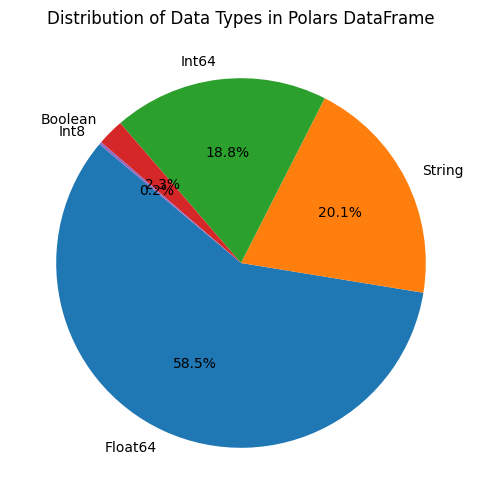




-------------------------------------------------



The head infomation of train datashape: (5, 861)
┌─────────┬──────────┬────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ case_id ┆ WEEK_NUM ┆ target ┆ month_deci ┆ … ┆ max_num_gr ┆ max_num_gr ┆ last_num_g ┆ last_num_g │
│ ---     ┆ ---      ┆ ---    ┆ sion       ┆   ┆ oup1_15    ┆ oup2_15    ┆ roup1_15   ┆ roup2_15   │
│ i64     ┆ i64      ┆ i64    ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│         ┆          ┆        ┆ i8         ┆   ┆ i64        ┆ i64        ┆ i64        ┆ i64        │
╞═════════╪══════════╪════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 0       ┆ 0        ┆ 0      ┆ 1          ┆ … ┆ null       ┆ null       ┆ null       ┆ null       │
│ 1       ┆ 0        ┆ 0      ┆ 1          ┆ … ┆ null       ┆ null       ┆ null       ┆ null       │
│ 2       ┆ 0        ┆ 0      ┆ 1          ┆ … ┆ null       ┆ null       ┆ null       ┆

AttributeError: 'DataFrame' object has no attribute 'isna'

In [37]:
print(f'The shape of train data{df_train.shape}')  # prints the number of rows and columns
print(f'The shape of test data{df_test.shape}')  # prints the number of rows and columns

print('\n\n\n-------------------------------------------------\n\n\n')
print(f'The columns of train data: \n\n {df_train.columns}')  # prints the column names
print('\n\n\n-------------------------------------------------\n\n\n')
print(f'The data types of train data: \n\n {df_train.dtypes}')  # prints the data types of the columns
print('\n\n\n-------------------------------------------------\n\n\n')

print('The distribution of data types in train data')
data_types = df_train.schema.values()
# Convert the data types to a pandas Series
data_types_series = pd.Series(data_types)
# Count the occurrences of each data type
data_type_counts = data_types_series.value_counts()
# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(data_type_counts, labels=data_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Data Types in Polars DataFrame')
plt.show()

print('\n\n\n-------------------------------------------------\n\n\n')


print(f'The head infomation of train data{df_train.head()}')  # prints the first few rows
print('\n\n\n-------------------------------------------------\n\n\n')


# Descriptive statistics
print('The summary statistics for train data')
print(df_train.describe())  # summary statistics for numerical columns

## Class Distribution in Training Dataset

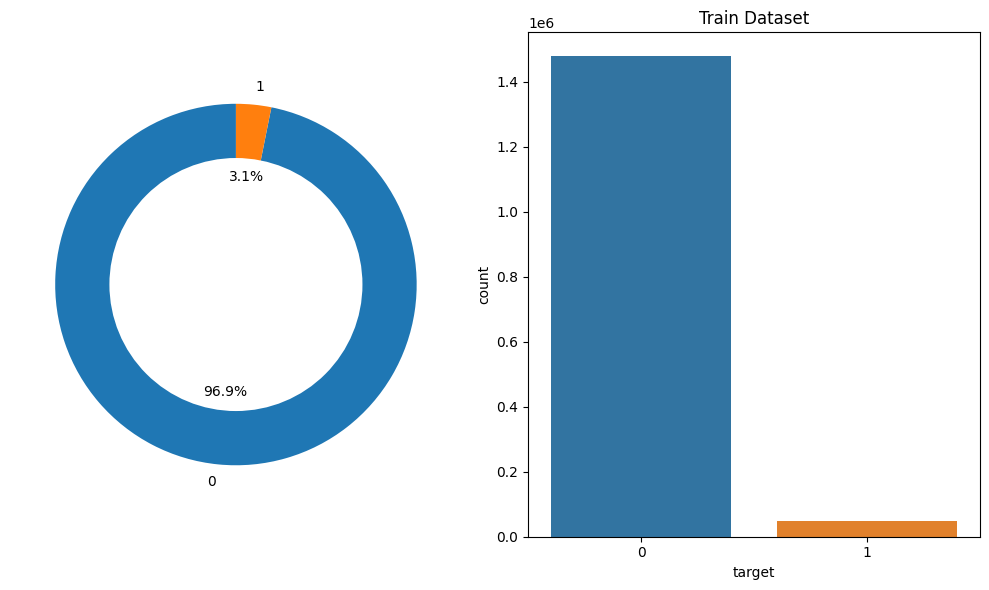

In [42]:
# Calculate the counts of each class in the target variable
target_counts = df_train.groupby('target').agg(pl.count()).sort('target')

# Convert to pandas DataFrame for plotting
target_counts_df = target_counts.to_pandas()

# Extract data for plotting
sizes = target_counts_df['count'].values
labels = target_counts_df['target'].astype(str).values

# Start plotting
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)

# Donut Chart
ax[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].add_artist(plt.Circle((0,0),0.70,fc='white'))

# Bar Chart
sns.barplot(x=labels, y=sizes, ax=ax[1])
ax[1].set_title('Train Dataset')
ax[1].set_ylabel('count')
ax[1].set_xlabel('target')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

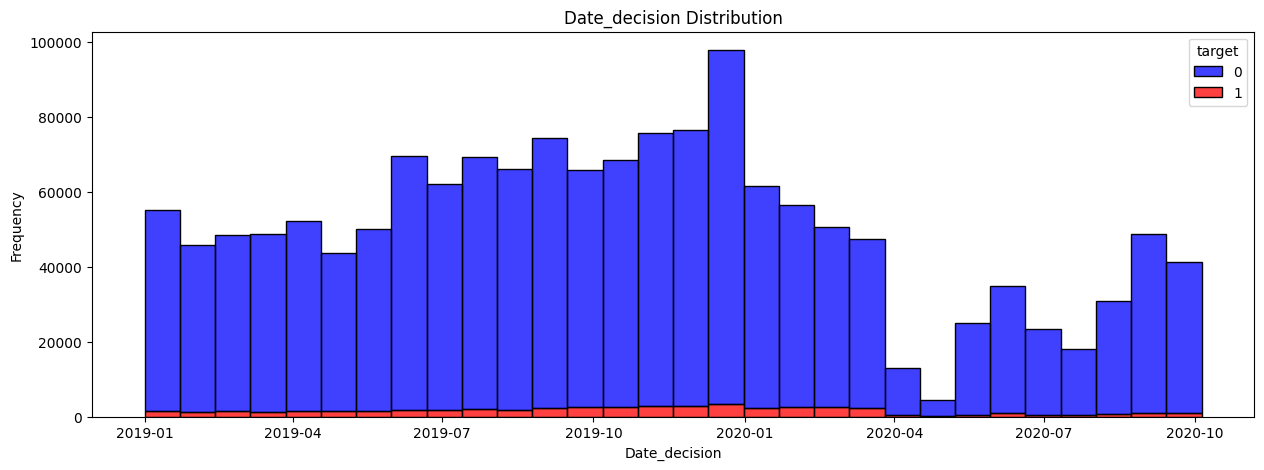

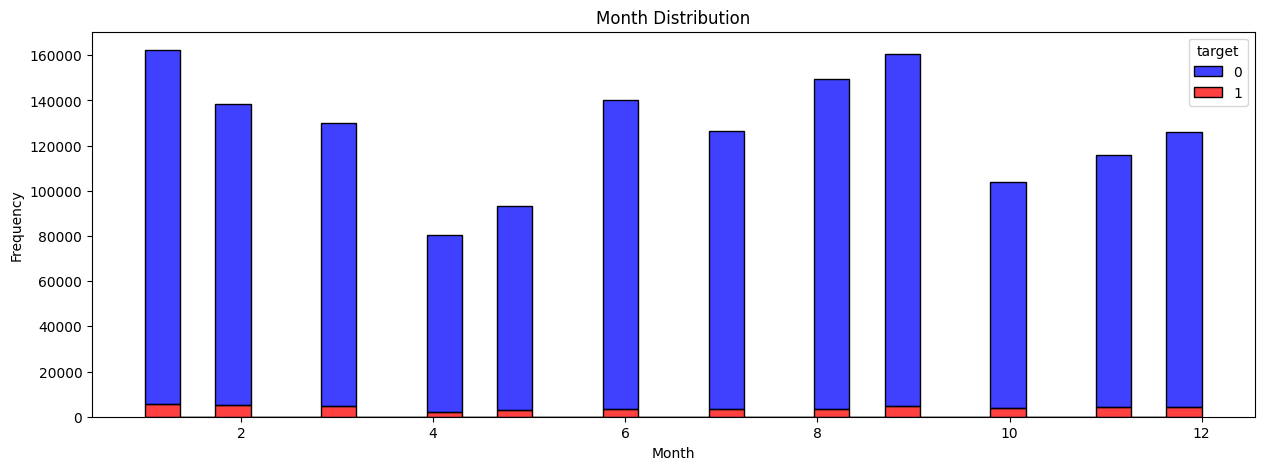

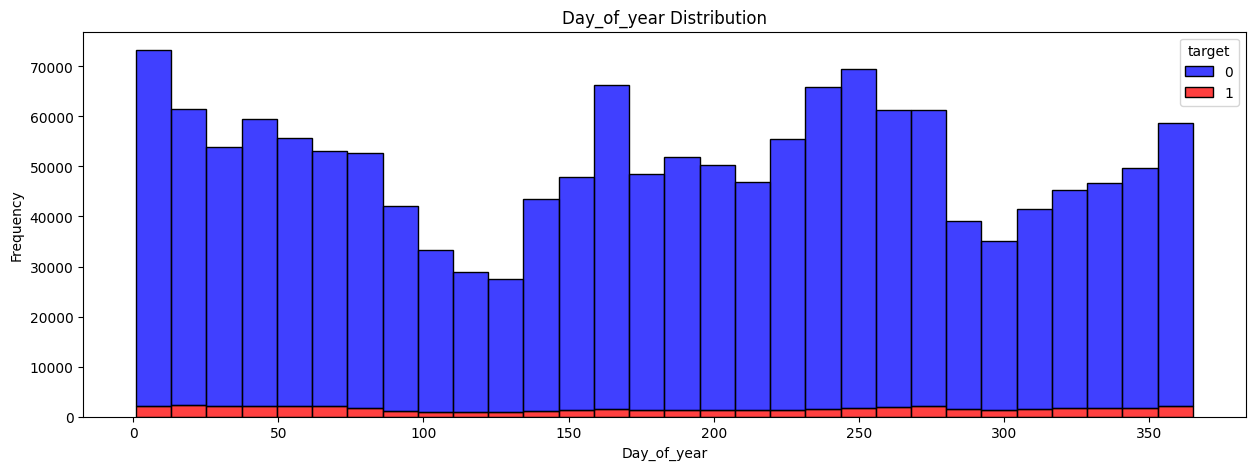

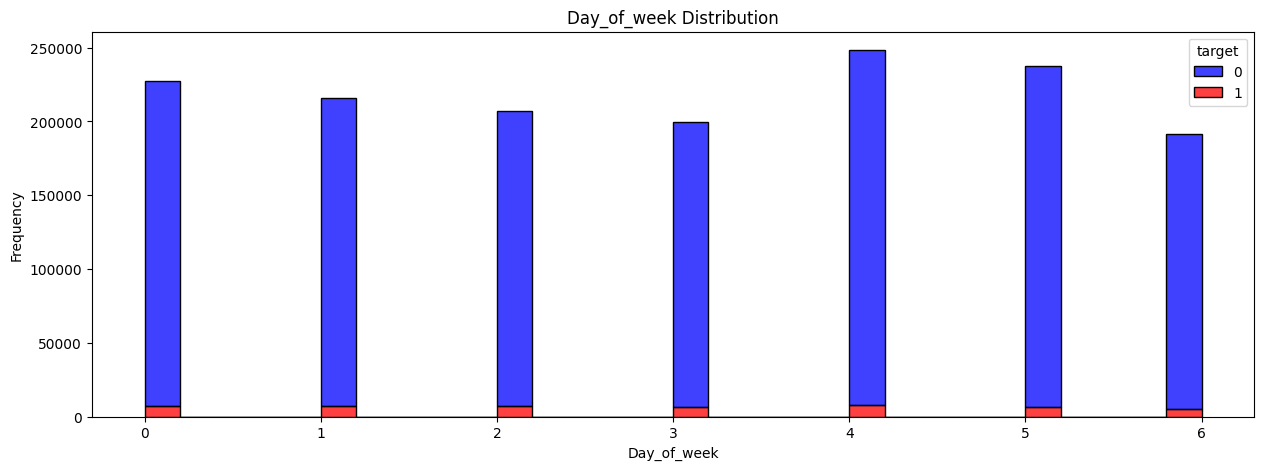

In [51]:
def plot_date_components_histogram_seaborn(df, component):
    PALETTE = ['blue', 'red']  # define your color palette here
    fig = plt.figure(figsize=(15, 5))
    sns.histplot(data=df, x=component, bins=30, multiple="stack", kde=False, hue='target',
                 palette=[PALETTE[0], PALETTE[1]])
    plt.title(f'{component.capitalize()} Distribution')
    plt.xlabel(component.capitalize())
    plt.ylabel('Frequency')
    plt.show()

def process_and_plot(df):
    # Convert 'date_decision' to datetime format
    df['date_decision'] = pd.to_datetime(df['date_decision'])
    
    # df['year'] = df.date_decision.dt.year-2019
    df['month'] = df.date_decision.dt.month
    df['day_of_year'] = df.date_decision.dt.day_of_year
    df['day_of_week'] = df.date_decision.dt.day_of_week

    plot_date_components_histogram_seaborn(df, 'date_decision')
    plot_date_components_histogram_seaborn(df, 'month')
    plot_date_components_histogram_seaborn(df, 'day_of_year')
    plot_date_components_histogram_seaborn(df, 'day_of_week')

# load the dataset
train_df =  pd.read_csv(PATH_BASE_TRAIN)

# process and plot the data
process_and_plot(train_df)

# After EDA, continue process the data

## Do the filter(drop high missing value col) for all cols, convert to pandas df & reduce the mem usage of df

In [ ]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)#优化后

## Get the group numerical Columns by Missing Value Counts 

In [ ]:
nums=df_train.select_dtypes(exclude='category').columns#排除分类变量，选择数值型
from itertools import combinations, permutations
#df_train=df_train[nums]
nans_df = df_train[nums].isna()#判断缺失值
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()#缺失值相加
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

# as the result, get the nans_groups
# {
#     0: ["column1", "column2"],  # No missing values in these columns
#     5: ["column3"],             # 5 missing values in column3
#     10: ["column4", "column5"], # 10 missing values in each of these columns
# }

## Define two helper func to handle nans_df

In [ ]:
# selecting columns based on the maximum number of unique values.
def reduce_group(groups):
    selected_columns = []  # This will store the column names selected from each group
    for group in groups:
        max_uniques = 0  # Initialize the maximum number of unique values found
        selected_column = group[0]  # Default to the first column in the group as a fallback
        
        for column in group:
            unique_count = df_train[column].nunique()  # Number of unique values in the column
            if unique_count > max_uniques:
                max_uniques = unique_count
                selected_column = column
        
        selected_columns.append(selected_column)
    
    print('Selected columns based on max uniques:', selected_columns)
    return selected_columns



def group_columns_by_correlation(dataframe, correlation_threshold=0.8):
    # Calculate the correlation matrix for the dataframe
    correlation_matrix = dataframe.corr()

    # Initialize a list to hold all groups of correlated columns
    correlated_groups = []

    # List of columns yet to be grouped
    remaining_columns = list(dataframe.columns)

    while remaining_columns:
        # Pop the first column name off the remaining list to create a new correlation group
        current_column = remaining_columns.pop(0)
        current_group = [current_column]
        correlated_columns = [current_column]  # This will hold all columns that correlate with `current_column`

        # Iterate over the remaining columns and check if the correlation with the current column is above the threshold
        for other_column in remaining_columns:
            if correlation_matrix.loc[current_column, other_column] >= correlation_threshold:
                current_group.append(other_column)
                correlated_columns.append(other_column)

        # Append the group to the list of groups
        correlated_groups.append(current_group)

        # Update remaining_columns by removing the correlated columns
        remaining_columns = [col for col in remaining_columns if col not in correlated_columns]

    return correlated_groups


## Select a subset of columns from a DataFrame based on their correlation and the number of NaN values

In [ ]:
# Initialize an empty list to store the columns to use
uses = []

# Loop over the groups of columns with the same number of NaNs
for k, v in nans_groups.items():
    # If the group has more than one column
    if len(v) > 1:
        # Get the columns in the group
        Vs = nans_groups[k]
        
        # Group the columns by their correlation
        grps = group_columns_by_correlation(df_train[Vs], threshold=0.8)
        
        # Reduce the groups to a list of columns to use
        use = reduce_group(grps)
        
        # Add the columns to the list of columns to use
        uses = uses + use
    else:
        # If the group has only one column, add it to the list of columns to use
        uses = uses + v
    
    print('####### NAN count =', k)

# Print the list of columns to use and its length
print(uses)
print(len(uses))

# Add the categorical columns to the list of columns to use
uses = uses + list(df_train.select_dtypes(include='category').columns)

# Print the new length of the list of columns to use
print(len(uses))

# Select only the columns to use from the DataFrame
df_train = df_train[uses]

##  Set up some parameters for model training 

In [ ]:
sample = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")
# device='gpu'
#n_samples=200000
n_est=6000
DRY_RUN = True if sample.shape[0] == 10 else False   
if DRY_RUN:
    device='cpu'
    df_train = df_train.iloc[:50000]
    #n_samples=10000
    n_est = 600
print(device)

# Continue process test data since we already load the test data for EDA

## Convert polars into pandas, reduce it usage by optimize its data type

In [ ]:
df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)

gc.collect()

# Check the Training and Test dataframe we used

In [ ]:
print(f'The shape of train data{df_train.shape}')  # prints the number of rows and columns
print(f'The shape of test data{df_test.shape}')  # prints the number of rows and columns

print('\n\n\n-------------------------------------------------\n\n\n')

# Feature preprocess

## Set up cross-validation

In [ ]:
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
df_train= df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)


## Convert the category cols to str

In [ ]:
df_train[cat_cols] = df_train[cat_cols].astype(str)
df_test[cat_cols] = df_test[cat_cols].astype(str)

## Check training data

In [ ]:
df_train

# Model training

## Define parameters

In [ ]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 5,  
    "learning_rate": 0.01,
    "n_estimators": 2000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.001,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':32,
    "device": device, 
    "verbose": -1,
}

params2 = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 5,
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "alpha": 0.001,  
    "lambda": 10,  
    "tree_method": 'gpu_hist' if device == 'gpu' else 'auto',
    "random_state": 42,
    "verbosity": 0,
    "enable_categorical":True,
}


## Training and Evaluating Models

In [ ]:
%time
from catboost import CatBoostClassifier, Pool
import xgboost as xgb

fitted_models_cat = []
fitted_models_lgb = []
fitted_models_xgb = []

cv_scores_cat = []
cv_scores_lgb = []
cv_scores_xgb = []


for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):#
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]# 
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    train_pool = Pool(X_train, y_train,cat_features=cat_cols)
    val_pool = Pool(X_valid, y_valid,cat_features=cat_cols)
    clf = CatBoostClassifier(
    eval_metric='AUC',
    task_type='GPU',
    learning_rate=0.05,
    iterations=n_est)
    random_seed=3107
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    fitted_models_cat.append(clf)
    y_pred_valid = clf.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_cat.append(auc_score)
    
    
    X_train[cat_cols] = X_train[cat_cols].astype("category")
    X_valid[cat_cols] = X_valid[cat_cols].astype("category")
    
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)] )
    
    fitted_models_lgb.append(model)
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_lgb.append(auc_score)
    
    
    model2 = xgb.XGBClassifier(**params2)
    model2.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=100, verbose=False)
    
    fitted_models_xgb.append(model2)
    
    y_pred_valid = model2.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores_xgb.append(auc_score)
    
    del clf, model, model2
    gc.collect()
    
    
print("CV AUC scores: ", cv_scores_cat)
print("Maximum CV AUC score: ", max(cv_scores_cat))


print("CV AUC scores: ", cv_scores_lgb)
print("Maximum CV AUC score: ", max(cv_scores_lgb))

print("CV AUC scores: ", cv_scores_xgb)
print("Maximum CV AUC score: ", max(cv_scores_xgb))


## Creating and Initializing a Voting Model

In [ ]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators[:5]]
        
        X[cat_cols] = X[cat_cols].astype("category")
        y_preds += [estimator.predict_proba(X) for estimator in self.estimators[5:10]]
        y_preds+=y_preds #tang trong so
        y_preds += [estimator.predict_proba(X) for estimator in self.estimators[10:]]
        print(len(y_preds))
        return np.mean(y_preds, axis=0)

model = VotingModel(fitted_models_cat+fitted_models_lgb+fitted_models_xgb)

## Training First Layer Models and Generating Meta-Features for Stacking

In [ ]:
from sklearn.model_selection import cross_val_predict
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd

# The first layer models
models = [
    ('CatBoost', CatBoostClassifier(eval_metric='AUC', task_type='GPU', learning_rate=0.05, iterations=n_est, random_seed=3107)),
    ('LightGBM', LGBMClassifier(**params)),
    ('XGBoost', XGBClassifier(**params2))
]

# The meta model
from sklearn.ensemble import GradientBoostingClassifier

params = {
    'n_estimators': 12,
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_samples_split': 3,
    'min_samples_leaf': 1
}

meta_model = GradientBoostingClassifier(**params)



# To store the fitted models and the cross-validated scores
fitted_models_cb = []
fitted_models_lgb = []
fitted_models_xgb = []
cv_scores_cb = []
cv_scores_lgb = []
cv_scores_xgb = []

# To store the meta features
meta_features = pd.DataFrame(index=df_train.index, columns=['CatBoost', 'LightGBM', 'XGBoost'])

for name, model in models:
    for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):
        X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]

        if name == 'CatBoost':
            X_train[cat_cols] = X_train[cat_cols].astype(str)
            X_valid[cat_cols] = X_valid[cat_cols].astype(str)
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            val_pool = Pool(X_valid, y_valid, cat_features=cat_cols)
            model.fit(train_pool, eval_set=val_pool, verbose=False)
            y_pred_valid = model.predict_proba(val_pool)[:, 1]
            fitted_models_cb.append(model)
            auc_score = roc_auc_score(y_valid, y_pred_valid)
            cv_scores_cb.append(auc_score)
        elif name == 'LightGBM':
            X_train[cat_cols] = X_train[cat_cols].astype('category')
            X_valid[cat_cols] = X_valid[cat_cols].astype('category')
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.log_evaluation(200), lgb.early_stopping(100)])
            fitted_models_lgb.append(model)
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            auc_score = roc_auc_score(y_valid, y_pred_valid)
            cv_scores_lgb.append(auc_score)
        else:  # XGBoost
            X_train[cat_cols] = X_train[cat_cols].astype('category')
            X_valid[cat_cols] = X_valid[cat_cols].astype('category')
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)
            fitted_models_xgb.append(model)
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            auc_score = roc_auc_score(y_valid, y_pred_valid)
            cv_scores_xgb.append(auc_score)

        meta_features.loc[X_valid.index, name] = y_pred_valid

## Training the Meta-Model

In [ ]:
meta_model.fit(meta_features, y)

# Submision

## Preprocessing Test Data

In [ ]:
df_test = df_test.drop(columns=["WEEK_NUM"])
df_test = df_test.set_index("case_id")

## Initializing DataFrame for Test Meta-Features

In [ ]:
test_meta_features = pd.DataFrame(index=df_test.index, columns=['CatBoost', 'LightGBM', 'XGBoost'])

## Generating Test Meta-Features with First Layer Models

In [ ]:
# CatBoost
for model in fitted_models_cat:
    df_test[cat_cols] = df_test[cat_cols].astype(str)
    y_pred_test = model.predict_proba(df_test)[:, 1]
    test_meta_features['CatBoost'] = test_meta_features['CatBoost'].add(y_pred_test, fill_value=0)

test_meta_features['CatBoost'] /= len(fitted_models_cat)

# LightGBM
for model in fitted_models_lgb:
    df_test[cat_cols] = df_test[cat_cols].astype("category")
    y_pred_test = model.predict_proba(df_test)[:, 1]
    test_meta_features['LightGBM'] = test_meta_features['LightGBM'].add(y_pred_test, fill_value=0)

test_meta_features['LightGBM'] /= len(fitted_models_lgb)

# XGBoost
for model in fitted_models_xgb:
    df_test[cat_cols] = df_test[cat_cols].astype("category")
    y_pred_test = model.predict_proba(df_test)[:, 1]
    test_meta_features['XGBoost'] = test_meta_features['XGBoost'].add(y_pred_test, fill_value=0)

test_meta_features['XGBoost'] /= len(fitted_models_xgb)

## Making Final Predictions with Meta-Model

In [ ]:
test_meta_features

y_pred = pd.Series(meta_model.predict_proba(test_meta_features)[:, 1], index=df_test.index)

## Creating and Saving Submission File

In [ ]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred
df_subm.to_csv("submission.csv")
df_subm